## framewsie
add adversarial attack FGSM on Image

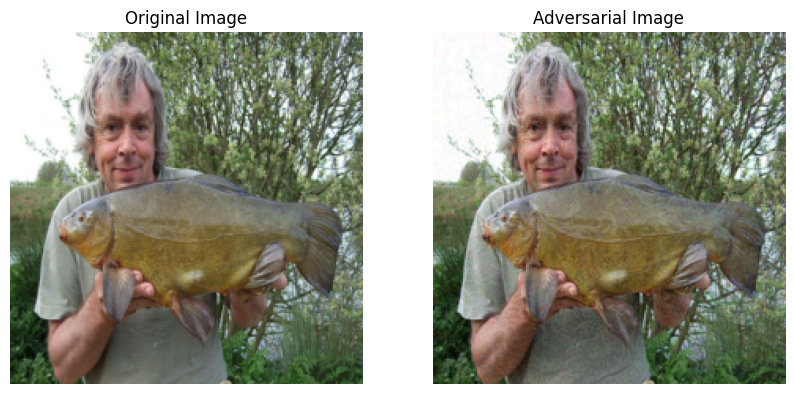

In [2]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# 加载预训练的ResNet101模型
model = models.resnet101(pretrained=True)
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# 图像预处理
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

def fgsm_attack(image, epsilon, data_grad):
    # 获取梯度的符号
    sign_data_grad = data_grad.sign()
    # 生成对抗样本
    perturbed_image = image + epsilon * sign_data_grad
    # 添加剪切以维持[0,1]范围
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

def generate_adversarial_example(image_path, epsilon=0.02):
    # 加载和预处理图像
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)
    image_tensor.requires_grad = True
    
    # 创建一个假目标标签（例如，类别0）
    target = torch.tensor([0], device=device)
    
    # 计算损失
    output = model(image_tensor)
    criterion = nn.CrossEntropyLoss()
    loss = criterion(output, target)
    
    # 反向传播
    model.zero_grad()
    loss.backward()
    
    # 收集数据梯度
    data_grad = image_tensor.grad.data
    
    # 调用FGSM攻击
    perturbed_image = fgsm_attack(image_tensor, epsilon, data_grad)
    
    # 返回原始图像和对抗样本
    return image_tensor.squeeze(0), perturbed_image.squeeze(0)

def show_images(original, adversarial):
    # 转换张量为可显示的图像
    def tensor_to_img(tensor):
        tensor = tensor.cpu().detach().numpy()
        tensor = tensor.transpose(1, 2, 0)
        tensor = np.clip(tensor, 0, 1)
        return tensor

    # 显示图像
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.imshow(tensor_to_img(original))
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(tensor_to_img(adversarial))
    plt.title('Adversarial Image')
    plt.axis('off')
    
    plt.show()


image_path = "/home/z/Music/st/Kinetics-400/RQ3/ILSVRC2012_val_00011993_n01440764.JPEG"
original, adversarial = generate_adversarial_example(image_path)
show_images(original, adversarial)

Framewise Attack to Video

In [12]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
import av
import numpy as np
from tqdm import tqdm
import os
from PIL import Image

model = models.resnet101(pretrained=True)
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon * sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

def generate_adversarial_frame(frame, epsilon=0.02):
    frame_pil = Image.fromarray(frame)
    image_tensor = transform(frame_pil).unsqueeze(0).to(device)
    image_tensor.requires_grad = True
    
    target = torch.tensor([0], device=device)
    
    output = model(image_tensor)
    criterion = nn.CrossEntropyLoss()
    loss = criterion(output, target)
    
    model.zero_grad()
    loss.backward()
    
    data_grad = image_tensor.grad.data
    
    perturbed_image = fgsm_attack(image_tensor, epsilon, data_grad)
    
    perturbed_frame = perturbed_image.squeeze(0).cpu().detach().numpy()
    perturbed_frame = perturbed_image.squeeze(0).cpu().detach().numpy()
    perturbed_frame = np.transpose(perturbed_frame, (1, 2, 0))
    perturbed_frame = np.clip(perturbed_frame * 255, 0, 255).astype(np.uint8)
    
    return perturbed_frame

def load_video(video_path):
    frames = []
    container = av.open(video_path)
    
    stream = container.streams.video[0]
    fps = stream.average_rate
    
    for frame in container.decode(video=0):
        frames.append(frame.to_rgb().to_ndarray())
    
    return np.stack(frames), fps

def save_video(frames, output_path, fps=30):
    container = av.open(output_path, mode='w')
    stream = container.add_stream('h264', rate=fps)
    
    height = frames.shape[1] - (frames.shape[1] % 2)
    width = frames.shape[2] - (frames.shape[2] % 2)
    
    stream.width = width
    stream.height = height
    stream.pix_fmt = 'yuv420p'
    
    for frame in frames:
        frame = frame[:height, :width]
        frame = av.VideoFrame.from_ndarray(frame, format='rgb24')
        packet = stream.encode(frame)
        container.mux(packet)
    
    packet = stream.encode(None)
    container.mux(packet)
    container.close()

def process_video(config):
    video_files = [f for f in os.listdir(config['video_directory']) if f.endswith('.mp4')]
    
    adv_video_dir = os.path.join(os.path.dirname(config['video_directory']), 'FGSM_Image_Framewise')
    os.makedirs(adv_video_dir, exist_ok=True)
    
    for video_file in tqdm(video_files, desc="Processing videos"):
        video_path = os.path.join(config['video_directory'], video_file)
        
        try:
        
            frames, fps = load_video(video_path)
            
  
            perturbed_frames = []
            for frame in tqdm(frames, desc=f"Processing frames in {video_file}", leave=False):
                perturbed_frame = generate_adversarial_frame(frame, config['epsilon'])
                perturbed_frames.append(perturbed_frame)
            
            perturbed_frames = np.stack(perturbed_frames)
            
            output_path = os.path.join(adv_video_dir, video_file)
            save_video(perturbed_frames, output_path, fps)
            
        except Exception as e:
            print(f"Error processing {video_file}: {str(e)}")
            continue

if __name__ == "__main__":
    config = {
        'video_directory': '/home/z/Music/st/Kinetics-400/RQ1/videos_val',
        'epsilon': 0.01
    }
    
    process_video(config)

/home/z/miniconda3/envs/mmxai/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/z/miniconda3/envs/mmxai/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Processing videos:  26%|██▌       | 5081/19796 [12:04:47<34:59:04,  8.56s/it]


KeyboardInterrupt: 

framewise evaluation

In [13]:
import torch
import av
import numpy as np
from tqdm import tqdm
import os
from transformers import TimesformerForVideoClassification, AutoImageProcessor
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

def load_video(video_path):
    frames = []
    container = av.open(video_path)
    
    # Get video info
    stream = container.streams.video[0]
    fps = stream.average_rate
    
    for frame in container.decode(video=0):
        frames.append(frame.to_rgb().to_ndarray())
    
    return np.stack(frames), fps

def load_labels(label_file):
    """Load video labels from file"""
    labels = {}
    with open(label_file, 'r') as f:
        for line in f:
            video_name, label = line.strip().split()
            labels[video_name.split('.')[0]] = int(label)
    return labels

def evaluate_videos(config):

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Using device: {device}")
    
    model = TimesformerForVideoClassification.from_pretrained(config['model_name']).to(device)
    processor = AutoImageProcessor.from_pretrained(config['model_name'])
    model.eval()
    
    video_labels = load_labels(config['label_file'])
    
    video_files = [f for f in os.listdir(config['video_directory']) if f.endswith('.mp4')]
    
    predictions = []
    true_labels = []
    
    for video_file in tqdm(video_files, desc="Processing videos"):
        video_name = video_file.split('.')[0]
        
        if video_name not in video_labels:
            print(f"Warning: No label found for {video_file}")
            continue
            
        true_label = video_labels[video_name]
        video_path = os.path.join(config['video_directory'], video_file)
        
        try:
            frames, _ = load_video(video_path)
            
            total_frames = len(frames)
            if total_frames > 8:
                start_idx = (total_frames - 8) // 2
                frames = frames[start_idx:start_idx + 8]
            elif total_frames < 8:

                padding = np.tile(frames[-1], (8 - total_frames, 1, 1, 1))
                frames = np.concatenate([frames, padding])
            
    
            inputs = processor(list(frames), return_tensors="pt").to(device)

            with torch.no_grad():
                outputs = model(**inputs)
                pred = outputs.logits.argmax(-1).cpu().numpy()[0]
            
            predictions.append(pred)
            true_labels.append(true_label)
            
        except Exception as e:
            print(f"Error processing {video_file}: {str(e)}")
            continue

    precision, recall, f1, _ = precision_recall_fscore_support(
        true_labels, predictions, average='weighted'
    )
    accuracy = accuracy_score(true_labels, predictions)

    print("\nEvaluation Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    

    results = {
        'accuracy': float(accuracy),
        'precision': float(precision),
        'recall': float(recall),
        'f1': float(f1)
    }
    
    return results

if __name__ == "__main__":
    config = {
        'model_name': 'facebook/timesformer-base-finetuned-k400',
        'video_directory': '/home/z/Music/st/Kinetics-400/RQ1/FGSM_Image_Framewise', 
        'label_file': '/home/z/Music/st/Kinetics-400/RQ1/kinetics400_val_list_videos.txt'  
    }
    
    results = evaluate_videos(config)

Using device: cuda


/home/z/miniconda3/envs/mmxai/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Processing videos: 100%|██████████| 5081/5081 [22:21<00:00,  3.79it/s]


Evaluation Results:
Accuracy: 0.5371
Precision: 0.6030
Recall: 0.5371
F1 Score: 0.5393



/home/z/miniconda3/envs/mmxai/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
